In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
# import pyvista as pv
# pv.set_jupyter_backend('trame')
from tqdm import tqdm
from scipy import interpolate, ndimage
from scipy.optimize import minimize, Bounds
import numba as nb

In [2]:
# %matplotlib notebook

## Meshgrid

In [3]:
n_grid = 200
x = np.linspace(-1.2,1.2,n_grid+1)
y = np.linspace(-1.2,1.2,n_grid+1)
z = np.linspace(0,0,1)

r_grid = np.meshgrid(x,y,z)

## Random wave

In [4]:
#### Wave vector distribution ####
k_mean = np.array([0,0,0])*np.pi
k_var  = (np.array([8,8,8])*np.pi)**2
k_cov  = np.diagflat(k_var)

def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

In [5]:
#### Superpositioning the random wave on regular grid ####
def sample_wave_grid(k_mean,k_cov,n_wave = 100):
    rho = np.zeros_like(r_grid[0])
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = sample_k(k_mean,k_cov)
        k_dot_r = np.sum([r_grid[x]*k_sample[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r + phi) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def sample_wave_grid_list(k_list, phi_list):
    rho = np.zeros_like(r_grid[0])
    for i in range(len(phi_list)):
        phi = phi_list[i] # random phase
        k_sample = k_list[i]
        k_dot_r = np.sum([r_grid[x]*k_sample[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r + phi) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
#     r_0 = r_grid[0]-0
#     r_1 = r_grid[1]-0
#     d2 = r_0**2+r_1**2
    
#     rho_basin = 1-1*np.exp(-d2/2/1**2)
    
    return rho

def penalty_grid(x,sigma=0.01,W=0.5):
    r_0 = r_grid[0]-x[0]
    r_1 = r_grid[1]-x[1]
    d2 = r_0**2+r_1**2
    
    rho = W*np.exp(-d2/2/sigma**2)
    
    return rho

In [6]:
#### Sampling and store sample_k ####
np.random.seed(114514)
n_wave = 100
k_list = [sample_k(k_mean,k_cov) for i in range(n_wave)]
phi_list = [np.random.rand()*2*np.pi for i in range(n_wave)]

#### Background ####
rho_bg = sample_wave_grid_list(k_list, phi_list)

In [7]:
def f_rho_2D(x,k_list,phi_list):
    '''
    x: X and Y coordinate
    Return rho on (X,Y,0)
    '''
    coord = np.r_[x,0]
    rho = 0
    for i in range(len(phi_list)):
        phi = phi_list[i] # random phase
        k_sample = k_list[i]
        k_dot_r = np.sum([coord[x]*k_sample[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r + phi) # cos(k_n.r + phi_n)
        rho += rho_i
        
    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def f_phi_p(x,x_0,sigma=0.01,W=0.5):
    coord_0 = [np.r_[x,0] for x in x_0]
    coord = np.r_[x,0]
    phi_p = np.sum([W*np.exp(-np.sum((coord-c)**2)/2/sigma**2) for c in coord_0])
    
    return phi_p

def f_basin(x):
    coord = np.r_[x,0]
    rho_basin = 4*np.sum((coord-np.array([0,0,0]))**4)
    
    return rho_basin

In [8]:
#### Energy minimization ####
x_0 = np.array([-0.1,0.1])
x_bounds = Bounds(lb=np.array([-1,-1]), ub=np.array([1,1]))

opti = minimize(f_rho_2D, x_0, args=(k_list,phi_list),
                method='L-BFGS-B',bounds=x_bounds,
                options={'gtol':1e-6},
                jac='2-point')
x_i = opti.x
x_i

array([-0.07916205,  0.10004646])

In [9]:
#### Basin filling ####
## a. Initialize
basin_list = [x_i]
x_list = [x_i]
rho_new = rho_bg.copy()
sigma=0.02
W=0.4

n_trial = 1000
for i in tqdm(range(n_trial)):
    # b. Activation step
    n_p = n_trial
    f_new = lambda x: (f_rho_2D(x,k_list,phi_list) + 
                       f_phi_p(x,x_list[-n_p:],sigma,W) + 
                       f_basin(x))
    rho_new += penalty_grid(x_list[-1],sigma,W)
    
    # c. Relaxation step
    d_b = 0.1
    x_min = max(x_list[-1][0]-d_b,-1)
    y_min = max(x_list[-1][1]-d_b,-1)
    x_max = min(x_list[-1][0]+d_b, 1)
    y_max = min(x_list[-1][1]+d_b, 1)
    x_bounds = Bounds(lb=np.array([x_min,y_min]), 
                      ub=np.array([x_max,y_max]))
    opti_phi_p = minimize(f_new, x_list[-1]+np.random.normal(0,0.01),
                method='L-BFGS-B',bounds=x_bounds,
#                 options={'maxfun':100},
                jac='2-point')
    
    x_new = opti_phi_p.x
    x_list.append(x_new)
    
    # d. Confirm the sampling of a new local minimum
    if f_phi_p(x_new,x_list[0:i+1],sigma,W)<W*0.01:
        basin_list.append(x_new)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]


In [10]:
basin_list

[array([-0.07916205,  0.10004646]),
 array([0.06053704, 0.12123106]),
 array([ 0.0170505 , -0.05509459]),
 array([-0.31208184,  0.1344706 ]),
 array([-0.30708526,  0.03854956]),
 array([0.09558038, 0.20638857]),
 array([0.23617395, 0.22159037]),
 array([0.33617395, 0.32159037]),
 array([0.14528184, 0.35051343]),
 array([0.22933986, 0.48529936]),
 array([-3.38930215e-05,  4.46911889e-01]),
 array([-0.07603569,  0.34861533]),
 array([-0.10023505,  0.5579505 ]),
 array([-0.18023524,  0.54563761]),
 array([-0.30480173,  0.61532054]),
 array([-0.38541274,  0.52561234]),
 array([-0.4376902 ,  0.44117485]),
 array([-0.44772634,  0.33547846]),
 array([-0.44787063,  0.25486331]),
 array([-0.47575778,  0.18341295]),
 array([-0.6703947,  0.1278868]),
 array([-0.59378691,  0.27643333]),
 array([-0.69378691,  0.34606689]),
 array([-0.64805326,  0.43443154]),
 array([-0.51928487,  0.53062243]),
 array([-0.54859035,  0.63858206]),
 array([-0.66008057,  0.59069927]),
 array([-0.77291665,  0.49867848])

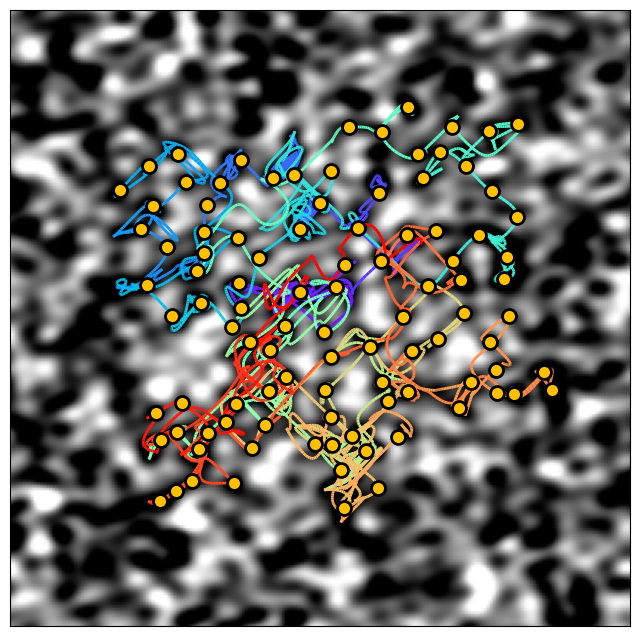

In [11]:
x_list = np.array(x_list)
basin_list = np.array(basin_list)

f_0 = interpolate.CubicSpline(np.arange(len(x_list))/n_trial,x_list[:,0])
f_1 = interpolate.CubicSpline(np.arange(len(x_list))/n_trial,x_list[:,1])
p = np.arange(10001)/10000

x_interp = np.array([f_0(p),f_1(p)]).T

points = x_interp.reshape(-1,1,2)
segments_list = np.hstack([points[:-1], points[1:]])

#### plotting
fig = plt.figure(figsize=(8,8))#,dpi=192)
ax = fig.add_subplot(1, 1, 1)

# pcolor
ax.pcolormesh(r_grid[0][:,:,0], r_grid[1][:,:,0], rho_bg[:,:,0], vmin=-1, vmax=2, 
              shading='gouraud',cmap='gray')

# points and line
lc = LineCollection(segments_list, cmap='rainbow',alpha=1,lw=2)
lc.set_array(p)
# ax.plot(x_list[:,0],x_list[:,1],'-k',zorder=1,alpha=0.25)
ax.add_collection(lc)
# ax.scatter(x_list[:,0],x_list[:,1],s=10,c=np.arange(n_trial+1),zorder=2,cmap='rainbow',alpha=0.5)
ax.plot(basin_list[:,0],basin_list[:,1],'o',zorder=3,alpha=1,
       mfc='#FFC000',mec='k',mew=2,ms=10)

# ax.set_xlabel(r'$x$',fontsize=20)
# ax.set_ylabel(r'$y$',fontsize=20)
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_xticks([])
ax.set_yticks([])
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# fig.patch.set_visible(False)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
plt.show()

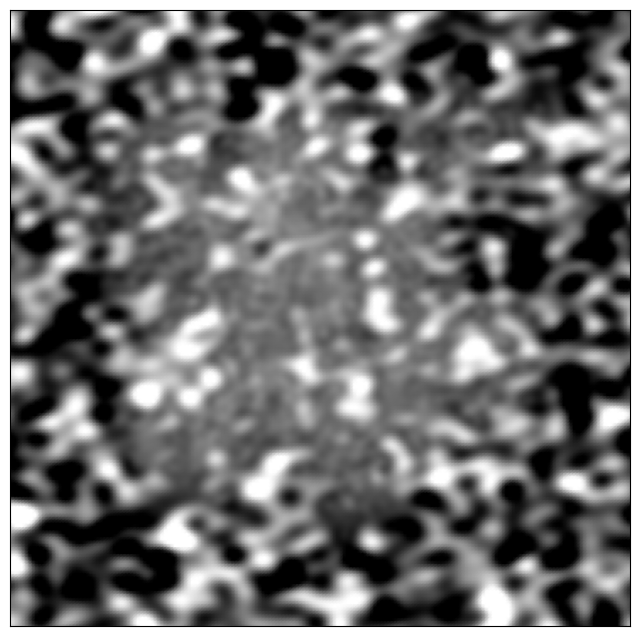

In [12]:
x_list = np.array(x_list)
basin_list = np.array(basin_list)

f_0 = interpolate.CubicSpline(np.arange(len(x_list))/n_trial,x_list[:,0])
f_1 = interpolate.CubicSpline(np.arange(len(x_list))/n_trial,x_list[:,1])
p = np.arange(10001)/10000

x_interp = np.array([f_0(p),f_1(p)]).T

points = x_interp.reshape(-1,1,2)
segments_list = np.hstack([points[:-1], points[1:]])

#### plotting
fig = plt.figure(figsize=(8,8))#,dpi=192)
ax = fig.add_subplot(1, 1, 1)

# pcolor
ax.pcolormesh(r_grid[0][:,:,0], r_grid[1][:,:,0], rho_new[:,:,0], vmin=-1, vmax=2, 
              shading='gouraud',cmap='gray')

# # points and line
# lc = LineCollection(segments_list, cmap='rainbow',alpha=1,lw=2)
# lc.set_array(p)
# # ax.plot(x_list[:,0],x_list[:,1],'-k',zorder=1,alpha=0.25)
# ax.add_collection(lc)
# # ax.scatter(x_list[:,0],x_list[:,1],s=10,c=np.arange(n_trial+1),zorder=2,cmap='rainbow',alpha=0.5)
# ax.plot(basin_list[:,0],basin_list[:,1],'o',zorder=3,alpha=1,
#        mfc='#FFC000',mec='k',mew=2,ms=10)

# ax.set_xlabel(r'$x$',fontsize=20)
# ax.set_ylabel(r'$y$',fontsize=20)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
plt.show()

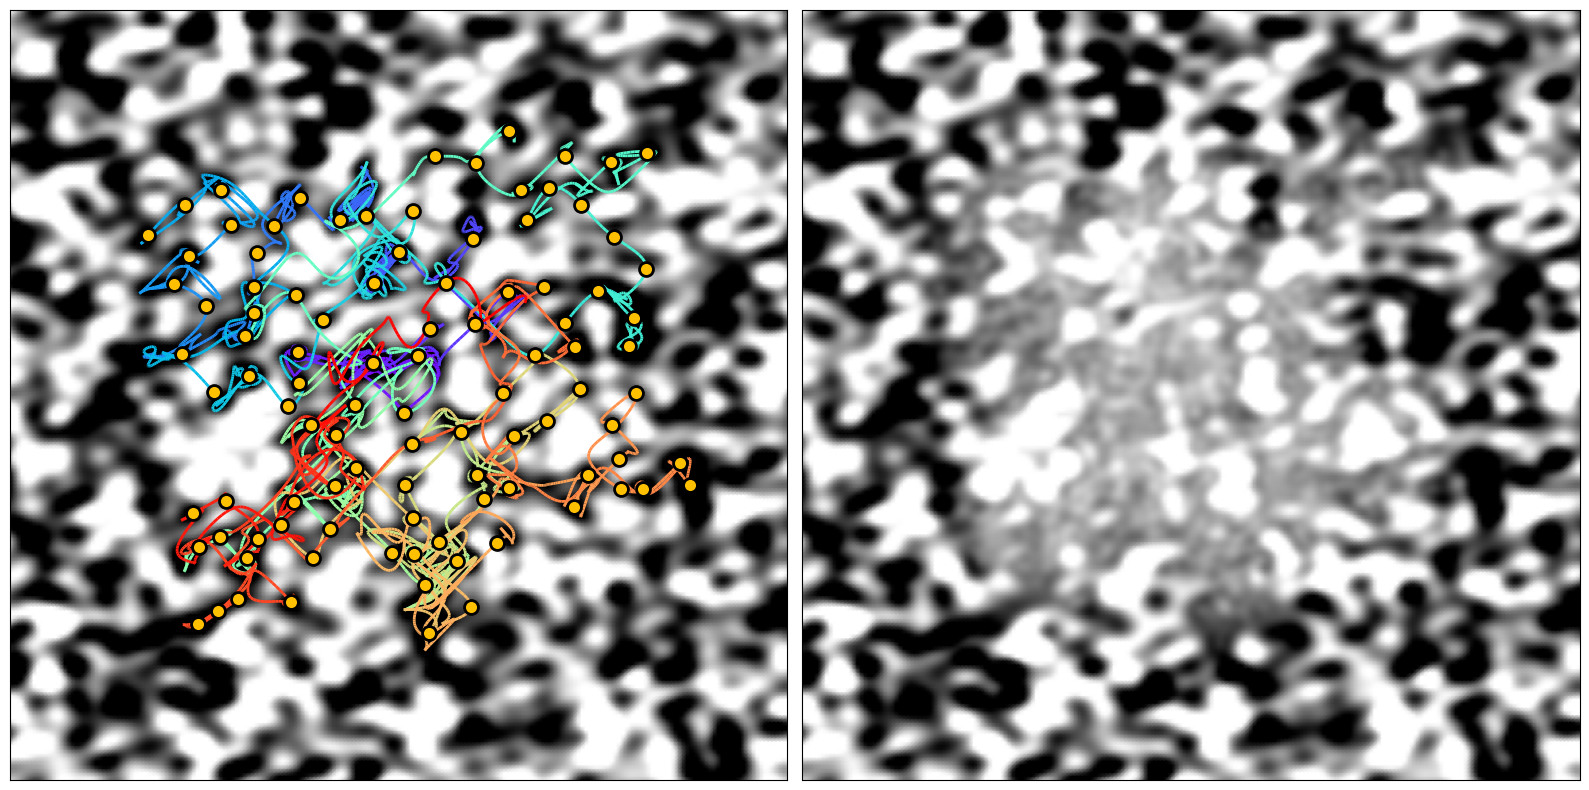

In [13]:
x_list = np.array(x_list)
basin_list = np.array(basin_list)

f_0 = interpolate.CubicSpline(np.arange(len(x_list))/n_trial,x_list[:,0])
f_1 = interpolate.CubicSpline(np.arange(len(x_list))/n_trial,x_list[:,1])
p = np.arange(10001)/10000

x_interp = np.array([f_0(p),f_1(p)]).T

points = x_interp.reshape(-1,1,2)
segments_list = np.hstack([points[:-1], points[1:]])

#### plotting
fig = plt.figure(figsize=(16,8))#,dpi=192)
ax = fig.add_subplot(1, 2, 1)

# pcolor
ax.pcolormesh(r_grid[0][:,:,0], r_grid[1][:,:,0], rho_bg[:,:,0], vmin=-1, vmax=1, 
              shading='gouraud',cmap='gray')

# points and line
lc = LineCollection(segments_list, cmap='rainbow',alpha=1,lw=2)
lc.set_array(p)
# ax.plot(x_list[:,0],x_list[:,1],'-k',zorder=1,alpha=0.25)
ax.add_collection(lc)
# ax.scatter(x_list[:,0],x_list[:,1],s=10,c=np.arange(n_trial+1),zorder=2,cmap='rainbow',alpha=0.5)
ax.plot(basin_list[:,0],basin_list[:,1],'o',zorder=3,alpha=1,
       mfc='#FFC000',mec='k',mew=2,ms=10)

# ax.set_xlabel(r'$x$',fontsize=20)
# ax.set_ylabel(r'$y$',fontsize=20)
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

ax = fig.add_subplot(1, 2, 2)

# pcolor
ax.pcolormesh(r_grid[0][:,:,0], r_grid[1][:,:,0], rho_new[:,:,0], vmin=-1, vmax=1, 
              shading='gouraud',cmap='gray')
# ax.imshow(rho_new[:,:,0]-rho_bg[:,:,0], vmin=0, vmax=2, 
#           interpolation='nearest', cmap='hot', extent=[-1.2, 1.2, -1.2, 1.2], origin='lower',
#           zorder=3,alpha=1)

# # points and line
# lc = LineCollection(segments_list, cmap='rainbow',alpha=1,lw=2)
# lc.set_array(p)
# # ax.plot(x_list[:,0],x_list[:,1],'-k',zorder=1,alpha=0.25)
# ax.add_collection(lc)
# # ax.scatter(x_list[:,0],x_list[:,1],s=10,c=np.arange(n_trial+1),zorder=2,cmap='rainbow',alpha=0.5)
# ax.plot(basin_list[:,0],basin_list[:,1],'o',zorder=3,alpha=1,
#        mfc='#FFC000',mec='k',mew=2,ms=10)

# ax.set_xlabel(r'$x$',fontsize=20)
# ax.set_ylabel(r'$y$',fontsize=20)
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
plt.tight_layout()
plt.show()